<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/06-common-design-building-blocks/04_residual_connections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Residual connections

We will discuss five new methods that work for feed-forward models and
one new improvement to RNNs. We introduce the first five methods roughly in the
order that they were invented, as each tends to use the preceding techniques in their
design. 

Individually, they improve accuracy and speed up training; but combined, they
are greater than the sum of their parts.

1. Better activation function
2. Batch/Layer normalization
3. Skip connections and 1 x 1 convolution
4. Residual connections
5. Long short-term memory (LSTM) layer

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from idlmam import train_network, Flatten, weight_reset, set_seed
from idlmam import LanguageNameDataset, pad_and_pack, EmbeddingPackable, LastTimeStep, LambdaLayer

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

torch.backends.cudnn.deterministic=True
set_seed(42)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

We use the
Fashion-MNIST dataset because it is slightly more challenging while retaining the same
size and shape as the original MNIST corpus, which will let us accomplish some testing
in a reasonable time.

In [ ]:
B = 128

train_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data, batch_size=B)

##Baseline model

Let’s define some basic hyperparameters.

In [ ]:
W, H = 28, 28
D = 28 * 28       # input size
n = 188           # Hidden layer size
C= 1              # How many channels are in the input?
n_filters = 32    # filters per convolutional layer
classes = 10      # How many classes are there?

In [ ]:
fc_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D,  n), 
  nn.Tanh(), #First hidden layer 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n,  n), nn.Tanh()) for _ in range(5)], 
  nn.Linear(n, classes),
)

In [ ]:
cnn_model = nn.Sequential(
  nn.Conv2d(C, n_filters, 3, padding=1),             
  nn.Tanh(),
  nn.Conv2d(n_filters, n_filters, 3, padding=1),     
  nn.Tanh(),
  nn.Conv2d(n_filters, n_filters, 3, padding=1),     
  nn.Tanh(),
  nn.MaxPool2d((2,2)),
  
  nn.Conv2d(  n_filters, 2*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.MaxPool2d((2,2)),

  nn.Conv2d(2*n_filters, 4*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.Conv2d(4*n_filters, 4*n_filters, 3, padding=1), 
  nn.Tanh(),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

We use our new train_network function to train all of the models.

In [ ]:
loss_func = nn.CrossEntropyLoss()

fc_results = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)

In [ ]:
cnn_results = train_network(cnn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)

In [ ]:
fc_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,17.090863,0.633577,0.461121,0.766650,0.837750
1,1,25.623105,0.434101,0.413325,0.845150,0.849067
2,2,32.654820,0.391224,0.358891,0.857450,0.867400
3,3,39.686018,0.363648,0.327916,0.868283,0.877617
4,4,47.563079,0.346689,0.332774,0.873750,0.883317


In [ ]:
cnn_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,17.229583,0.491520,0.315718,0.82165,0.885933
1,1,30.134080,0.320271,0.300401,0.88580,0.892483
2,2,44.177943,0.283402,0.227856,0.90060,0.918867
3,3,57.187276,0.256085,0.238842,0.90905,0.912200
4,4,70.143964,0.246041,0.245748,0.91435,0.917450


Let’s be explicit and tell Python we are finished so we can get back the GPU memory.

In [ ]:
del fc_model
del cnn_model

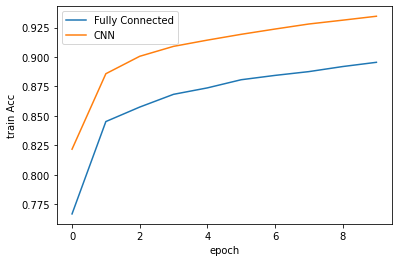

In [ ]:
sns.lineplot(x="epoch", y="train Acc", data=fc_results, label="Fully Connected")
sns.lineplot(x="epoch", y="train Acc", data=cnn_results, label="CNN")

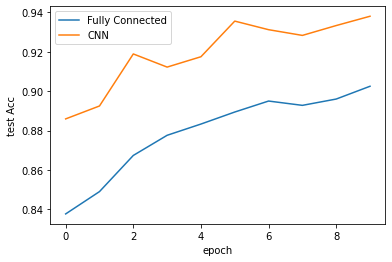

In [ ]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="Fully Connected")
sns.lineplot(x="epoch", y="test Acc", data=cnn_results, label="CNN")

##ReLU Baseline

In [ ]:
# How much I want the LeakyReLU to "leak" by. Anything in [0.01, 0.3] would have been fine.
leak_rate = 0.1

fc_relu_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D,  n), 
  nn.LeakyReLU(leak_rate), 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n,  n), nn.LeakyReLU(leak_rate)) for _ in range(5)], 
  nn.Linear(n, classes),
)

In [ ]:
def cnn_layer(in_filters, out_filters=None, kernel_size=3):
  """
  in_filters: how many channels are coming into the layer
  out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
  kernel_size: how large the kernel should be
  """
  if out_filters is None:
    # This is a common pattern, so lets automate it as a default if not asked
    out_filters = in_filters 
  # padding to stay the same size
  padding = kernel_size // 2
  # Combine the layer and activation into a single unit
  return nn.Sequential(
    nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
    nn.LeakyReLU(leak_rate)
  )

In [ ]:
cnn_relu_model = nn.Sequential(
  cnn_layer(C, n_filters),
  cnn_layer(n_filters),
  cnn_layer(n_filters),
  nn.MaxPool2d((2,2)),
  
  cnn_layer(n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters),
  cnn_layer(2 * n_filters),
  nn.MaxPool2d((2,2)),

  cnn_layer(2 * n_filters, 4 * n_filters),
  cnn_layer(4 * n_filters),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

In [ ]:
fc_relu_results = train_network(fc_relu_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del fc_relu_model

In [ ]:
cnn_relu_results = train_network(cnn_relu_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del cnn_relu_model

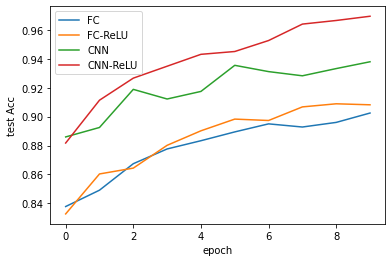

In [ ]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="FC")
sns.lineplot(x="epoch", y="test Acc", data=fc_relu_results, label="FC-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=cnn_results, label="CNN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_relu_results, label="CNN-ReLU")

##Batch Normalization Baseline

In [ ]:
fc_bn_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D, n), 
  nn.BatchNorm1d(n),
  nn.LeakyReLU(leak_rate), 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n, n), nn.BatchNorm1d(n), nn.LeakyReLU(leak_rate)) for _ in range(5)], 
  nn.Linear(n, classes),
)

In [ ]:
def cnn_layer(in_filters, out_filters=None, kernel_size=3):
  """
  in_filters: how many channels are coming into the layer
  out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
  kernel_size: how large the kernel should be
  """
  if out_filters is None:
    # This is a common pattern, so lets automate it as a default if not asked
    out_filters = in_filters 
  # padding to stay the same size
  padding = kernel_size // 2
  # Combine the layer and activation into a single unit
  return nn.Sequential(
    nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
    nn.BatchNorm2d(out_filters),  # The only change: adding BatchNorm2d after our convolution
    nn.LeakyReLU(leak_rate)
  )

In [ ]:
cnn_bn_model = nn.Sequential(
  cnn_layer(C, n_filters),
  cnn_layer(n_filters),
  cnn_layer(n_filters),
  nn.MaxPool2d((2,2)),
  
  cnn_layer(n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters),
  cnn_layer(2 * n_filters),
  nn.MaxPool2d((2,2)),

  cnn_layer(2 * n_filters, 4 * n_filters),
  cnn_layer(4 * n_filters),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

We are ready to train both models.

In [ ]:
fc_bn_results = train_network(fc_bn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del fc_bn_model

In [ ]:
cnn_bn_results = train_network(cnn_bn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del cnn_bn_model

Let’s compare it with baseline model.

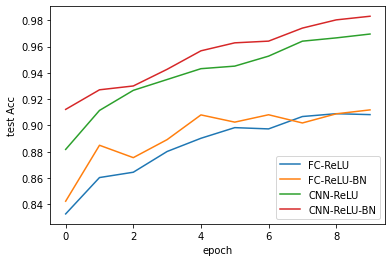

In [ ]:
sns.lineplot(x="epoch", y="test Acc", data=fc_relu_results, label="FC-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=fc_bn_results, label="FC-ReLU-BN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_relu_results, label="CNN-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=cnn_bn_results, label="CNN-ReLU-BN")

##Residual connections

If we combine skip connections and $1x1$ convolutions in just the right way, we get an approach called a **residual connection**
that converges faster to more accurate solutions.

The first connection type is a residual block. The block is a kind of
skip connection where two layers combine at the end, creating long and short paths.

However, in a residual block, the short path has no operations. We simply leave the input
unaltered!

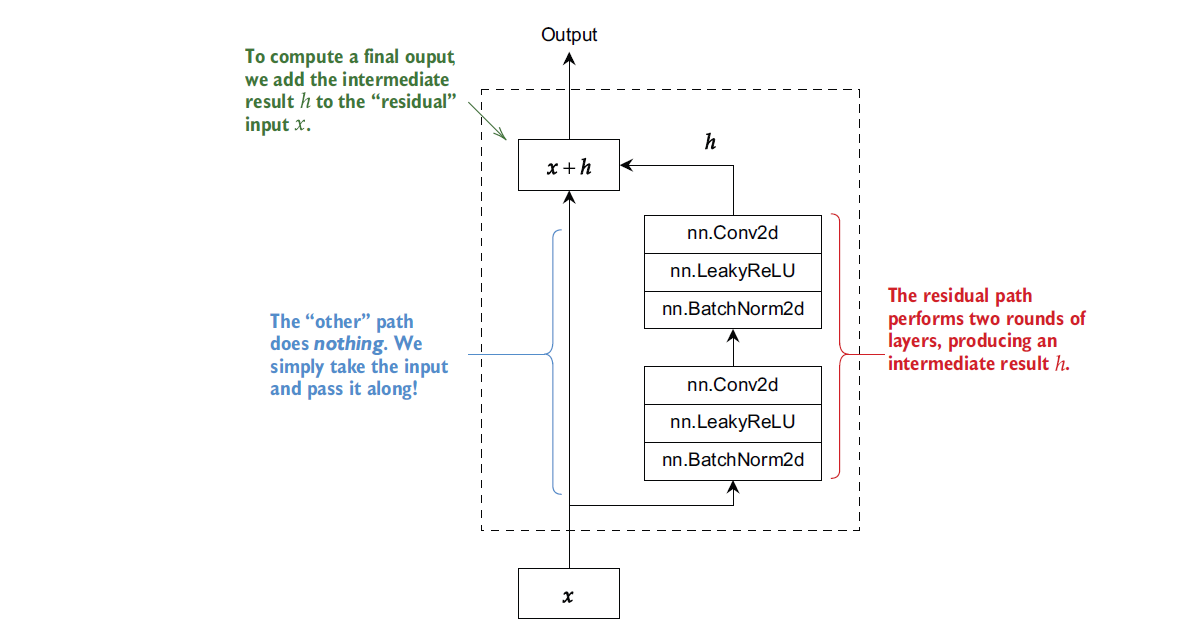

When we start combining multiple residual blocks one after another, we create an
architecture with a very interesting design. You can see, where we end
up with a long path and a short path through the network. The short path makes it easier
to learn deep architectures by having as few operations as possible. 

Fewer operations
means less chance of noise in the gradient, making it easy to propagate a useful gradient
back farther than would otherwise be possible. 

The long path then performs the actual
work, learning units of complexity that are added back in via the skip connections (using
addition instead of concatenation).

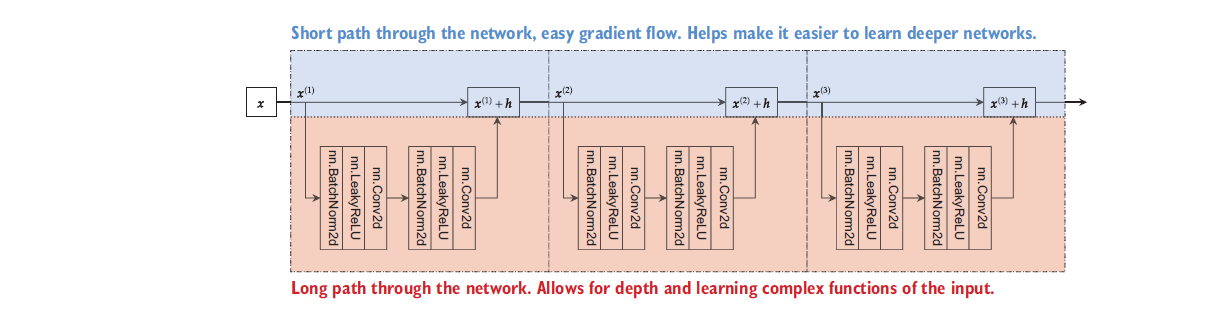

###Residual blocks

The residual block requires that the input and output have the
exact same shape because we are using addition instead of concatenation. 

This is where
the bottleneck layer helps.

The residual block we have described is called Type E and is one of the favored residual
setups.

In [ ]:
class ResidualBlockE(nn.Module):
  def __init__(self, channels, kernel_size=3, leak_rate=0.1):
    super().__init__()
    # how much padding will our convolutional layers need to maintain the input shape
    pad = (kernel_size - 1) // 2

    # Define the conv an BN layers we will use in a sub-network, just 2 hidden layers of conv/BN/activation
    self.F = nn.Sequential(
      nn.Conv2d(channels, channels, kernel_size, padding=pad),
      nn.BatchNorm2d(channels),
      nn.LeakyReLU(leak_rate),

      nn.Conv2d(channels, channels, kernel_size, padding=pad),
      nn.BatchNorm2d(channels),
      nn.LeakyReLU(leak_rate),
    )

  def forward(self, x):
    # combine the long path and short path
    return x + self.F(x)

###Residual bottlenecks